---
format: 
  html:
    toc: false
    page-layout: full
execute:
    echo: false
---

In [33]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.enums import Resampling
from rasterio.transform import from_origin
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import plotly.express as px
import colorcet as cc
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.graph_objects as go


np.random.seed(42)

Specify input and output directories and color palette

In [34]:
version = 'v5'
sampling_fraction = '1'

inputs = "/Users/oliveratwood/Documents/GitHub/HotspotStoplight/LandCoverChange/data/outputs/cropped/crop5c_30m/"
outputs = f'/Users/oliveratwood/Documents/GitHub/HotspotStoplight/clustering/data/outputs/crop5c_30m/{version}/'

alignment = '/Users/oliveratwood/Documents/GitHub/HotspotStoplight/LandCoverChange/data/outputs/cropped/crop5c_30m/population.tif'

Load Datasets

In [35]:
# Assuming the path to your datasets
data_folder = inputs
datasets = [
    "OtherProbability.tif",
    "BII.tif"
]

# Load datasets into a list of arrays
raster_arrays = []
titles = [
    'OtherProbability',
    'BII'
]

for dataset in datasets:
    with rasterio.open(f"{data_folder}/{dataset}") as src:
        raster_arrays.append(src.read(1))  # Read the first band

Plot Datasets

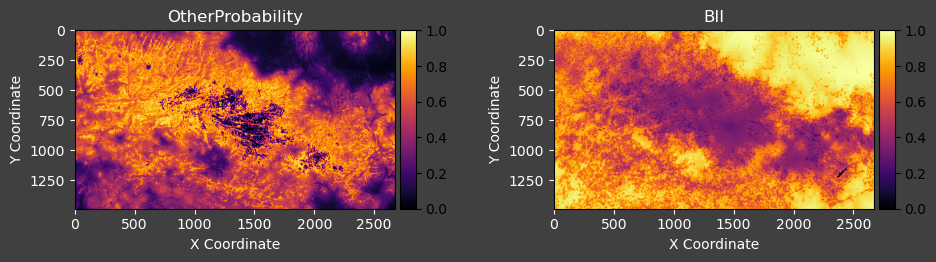

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('default')  # Reset matplotlib styles

# Assuming raster_arrays and titles are defined
# Calculate the size of the figure dynamically based on the number of plots
num_plots = len(raster_arrays)
rows = (num_plots + 1) // 2  # Adjust rows based on number of plots, assuming 2 columns

fig_width = 10  # Fixed width for each subplot column
fig_height_per_row = 5  # Approximate height per row

fig, axs = plt.subplots(rows, 2, figsize=(fig_width, fig_height_per_row * rows))
fig.patch.set_facecolor('#404040')  # Set the figure background to dark grey

# If axs is not an array of arrays when there's only one row, make it so
if num_plots <= 2:
    axs = np.array([axs])

for i, (data, title) in enumerate(zip(raster_arrays, titles)):
    row, col = divmod(i, 2)
    im = axs[row, col].imshow(data, cmap='inferno')
    axs[row, col].set_title(title, color='white')
    axs[row, col].set_xlabel('X Coordinate', color='white')
    axs[row, col].set_ylabel('Y Coordinate', color='white')
    axs[row, col].tick_params(colors='white')  # Change tick colors to white
    
    # Create an axis for the colorbar next to each subplot
    divider = make_axes_locatable(axs[row, col])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

# Hide unused subplots if any
grid_size = rows * 2  # Rows x Columns
for i in range(num_plots, grid_size):
    row, col = divmod(i, 2)
    axs[row, col].axis('off')

plt.tight_layout(pad=3.0)  # Adjust layout for the overall figure, add padding for aesthetics
plt.show()  # Display the plot


In [37]:
def load_specified_rasters_to_dataframe(data_folder, datasets):
    """
    Load specified raster datasets from a folder, extract spatial coordinates, flatten the data,
    and combine into a pandas DataFrame.

    Parameters:
    - data_folder: str, the path to the folder containing the raster files.
    - datasets: list of str, the filenames of the raster datasets to process.

    Returns:
    - pandas.DataFrame containing the flattened data of all specified rasters along with their spatial coordinates.
    """
    data_arrays = []
    coordinate_arrays = None
    for filename in datasets:
        with rasterio.open(f"{data_folder}/{filename}") as dataset:
            # Calculate coordinates if this is the first dataset
            if coordinate_arrays is None:
                rows, cols = np.indices((dataset.height, dataset.width))
                xs, ys = rasterio.transform.xy(dataset.transform, rows, cols, offset='center')
                coordinate_arrays = {'x': np.array(xs).flatten(), 'y': np.array(ys).flatten()}
            
            # Read the raster data and flatten
            data_array = dataset.read(1).flatten()
            data_arrays.append(data_array)
    
    # Combine coordinates with data into a single dictionary
    data_dict = coordinate_arrays.copy()
    for filename, array in zip(datasets, data_arrays):
        # Use filename as key but remove the file extension for the column name
        column_name = filename.split('.')[0]
        data_dict[column_name] = array
    
    # Create DataFrame
    df = pd.DataFrame(data_dict)
    
    # Optionally, drop rows with NaN values
    df.dropna(inplace=True)
    
    return df

# Use the function with the specified folder and datasets
df = load_specified_rasters_to_dataframe(data_folder, datasets)

# Display the first few rows of the DataFrame to verify
print(df.head())


           x          y  OtherProbability       BII
0 -84.482406  10.158081          0.447622  0.903655
1 -84.482128  10.158081          0.427885  0.903858
2 -84.481851  10.158081          0.382418  0.904061
3 -84.481573  10.158081          0.404804  0.904021
4 -84.481295  10.158081          0.436384  0.902486


Sample the dataframe to decrease run time

In [38]:
# Sample the DataFrame
sampling_fraction = float(sampling_fraction)
df = df.sample(frac=sampling_fraction)

Standardize the data columns for clustering

In [39]:
# Standardization
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(df[titles])

Perform K-means clustering

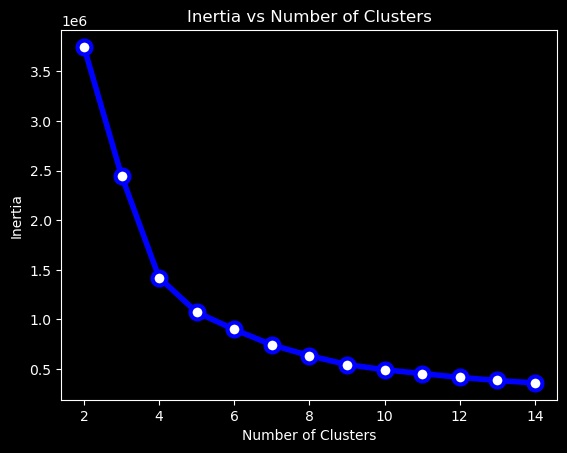

In [40]:
from sklearn.cluster import KMeans

# Number of clusters to try out
n_clusters = list(range(2, 15))

# Run kmeans for each value of k
inertias = []
for k in n_clusters:
    
    # Initialize and run
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=600)
    kmeans.fit(X)
    
    # Save the "inertia"
    inertias.append(kmeans.inertia_)
    
# Plot it!
# Set a dark background style for the plot
plt.style.use('dark_background')

# Plotting the data
plt.plot(n_clusters, inertias, marker='o', ms=10, mfc='white', lw=4, mew=3, color='blue')

# Setting labels and title with light color for visibility
plt.title('Inertia vs Number of Clusters', color='white')
plt.xlabel('Number of Clusters', color='white')
plt.ylabel('Inertia', color='white')

# Display the plot
plt.show()


Determine the appropriate number of clusters using KneeLocator

In [41]:
from kneed import KneeLocator

# Initialize the knee algorithm
kn = KneeLocator(n_clusters, inertias, curve='convex', direction='decreasing')

# Print out the knee 
print(kn.knee)

5


Fit the appropriate number of clusters to the data

In [42]:
# Initialize the Kmeans object
# Using the identified knee
kmeans = KMeans(n_clusters=(kn.knee), random_state=42, n_init=10)

# Using a manually-assigned knee (optional)
# kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Run the fit! This adds the ".labels_" attribute
kmeans.fit(X);

# Save the cluster labels
df["cluster"] = kmeans.labels_

df.head()

,x,y,OtherProbability,BII,cluster
84220,-84.088333,10.149473,0.086317,0.949913,4
629103,-84.088611,10.092828,0.465248,0.736277,1
483249,-83.796735,10.108100,0.102904,0.956294,4
378174,-84.048342,10.118929,0.078149,0.965557,4
1766522,-84.207194,9.974538,0.006000,0.394966,2


In [43]:
# Count the number of rows for each cluster and sort them to see which clusters have the greatest number of rows
cluster_counts = df['cluster'].value_counts().sort_values(ascending=False)

# Display the counts
print('Number of Pixels per Cluster')
print(cluster_counts)
# print(df.dtypes)

Number of Pixels per Cluster
cluster
3    1047968
1    1047112
0     854299
4     803017
2     227394
Name: count, dtype: int64


In [44]:
# Convert index and values to lists for plotting
clusters = cluster_counts.index.tolist()
counts = cluster_counts.values.tolist()

# Define minimum and maximum marker sizes
min_size = 10  # Minimum marker size in pixels
max_size = 150  # Maximum marker size in pixels

# Normalize the counts to scale between min_size and max_size
max_count = max(counts)
normalized_sizes = [(count / max_count) * (max_size - min_size) + min_size for count in counts]

# Mapping cluster IDs to specific colors for discrete legend entries
color_map = {cluster: color for cluster, color in zip(clusters, px.colors.qualitative.Plotly)}

# Initialize the figure
fig = go.Figure()

# Add scatter trace for each cluster
for cluster, size, count in zip(clusters, normalized_sizes, counts):
    fig.add_trace(go.Scatter(
        x=[cluster],
        y=[1],  # Y-values are constant; they only serve to display the relative sizes
        mode='markers',
        marker=dict(
            size=[size],
            color=[color_map[cluster]],  # Use specific color for each cluster
            opacity=0.5
        ),
        name=f'Cluster {cluster}: {count}',  # Name each trace to appear in the legend
    ))

# Update the layout for dark mode and adjust axis lines
fig.update_layout(
    title='Number of Pixels per Cluster',
    title_font_color='white',
    paper_bgcolor='#303030',
    plot_bgcolor='#303030',
    xaxis=dict(
        title='Cluster',
        title_font_color='white',
        tickfont_color='white',
        gridcolor='#505050',
        showline=True,
        linewidth=2,
        linecolor='white',
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='#505050',  # Adjust 0 axis line to match the grid
    ),
    yaxis=dict(
        showticklabels=False,
        gridcolor='#505050',
        showline=True,
        linewidth=2,
        linecolor='white',
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='#505050',  # Adjust 0 axis line to match the grid
    ),
    legend=dict(
        font_color='white',
        bgcolor='#404040',
        title_font_color='white'
    )
)

# Show the interactive plot
fig.show()


Make a violin chart for each cluster

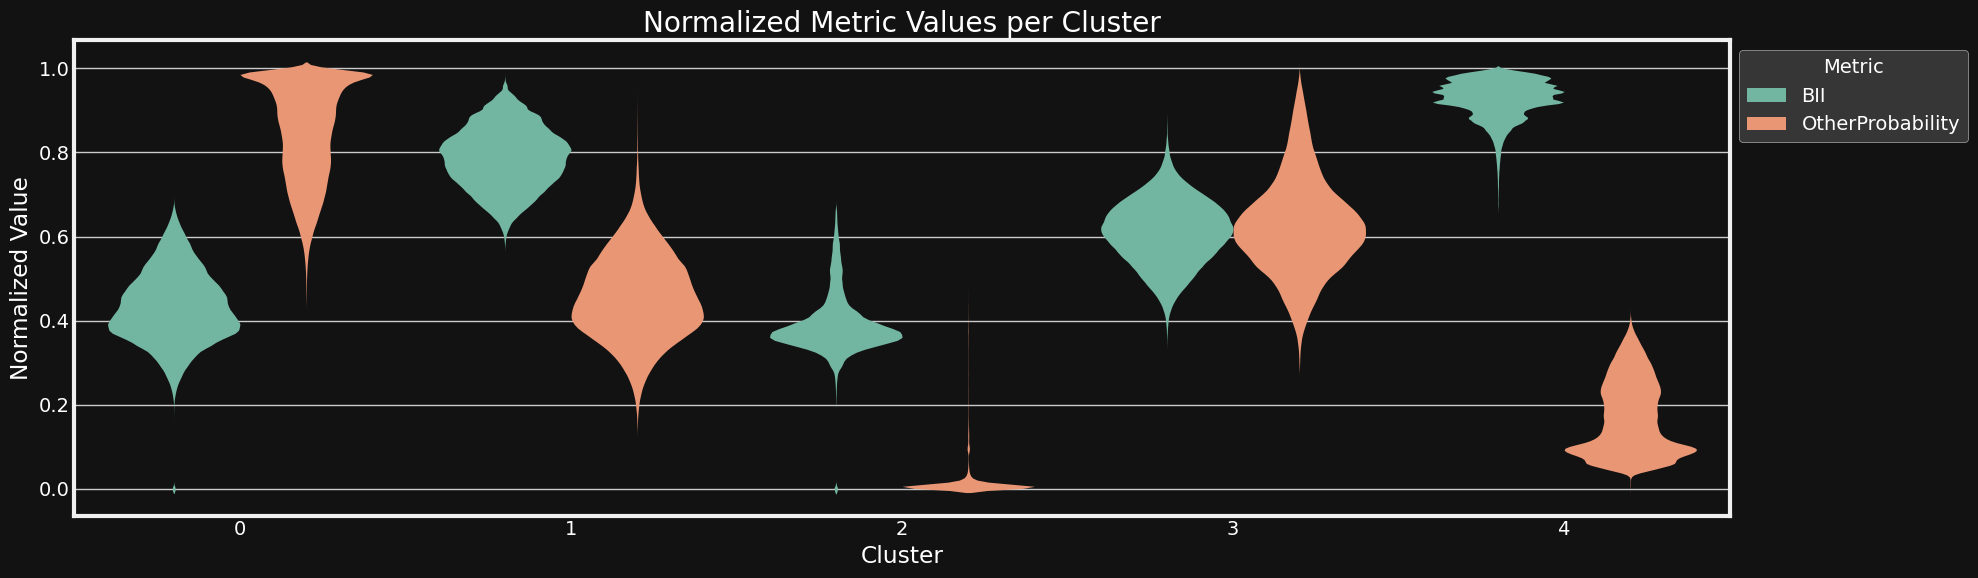

In [45]:
# Convert df to long format
# Select columns to include in the melt operation, excluding 'x' and 'y'
columns_to_melt = df.columns.difference(['x', 'y', 'cluster'])

# Perform the melt operation with the selected columns
long_df = pd.melt(df, id_vars=['cluster'], value_vars=columns_to_melt, var_name='Metric', value_name='Normalized Value')

# Assuming long_df is prepared and ready for plotting
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(20, 6))
fig.patch.set_facecolor('#121212')
ax.set_facecolor('#121212')

# Draw violin plots with violins scaled by the count of observations in each cluster
violin_parts = sns.violinplot(x='cluster', y='Normalized Value', hue='Metric', data=long_df,
                              palette='Set2', split=False, linewidth=0, scale='count')

# Customizations for text color, etc.
ax.set_title('Normalized Metric Values per Cluster', color='white')
ax.set_xlabel('Cluster', color='white')
ax.set_ylabel('Normalized Value', color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Change the legend's background color to dark grey
legend = ax.legend(title='Metric', bbox_to_anchor=(1, 1), loc='upper left')
plt.setp(legend.get_texts(), color='white')  # Set the legend text color to white
plt.setp(legend.get_title(), color='white')  # Set the legend title color to white
legend.get_frame().set_facecolor('#404040')  # Dark grey background for the legend

plt.tight_layout()
plt.show()


1 is a moderate of bio risk - it is the largest cluster
2 is a cluster of moderate climate risk
3 and 4 and 5 are higher bio risk areas
3 has highest exurban development potential, but with lower BII values than 4 and 5
5 has highest climate and bio risk areas
4 has highest integrated risk value


Plot the clusters across space, in ascending order of biodiversity loss risk (BII * OtherProbability)

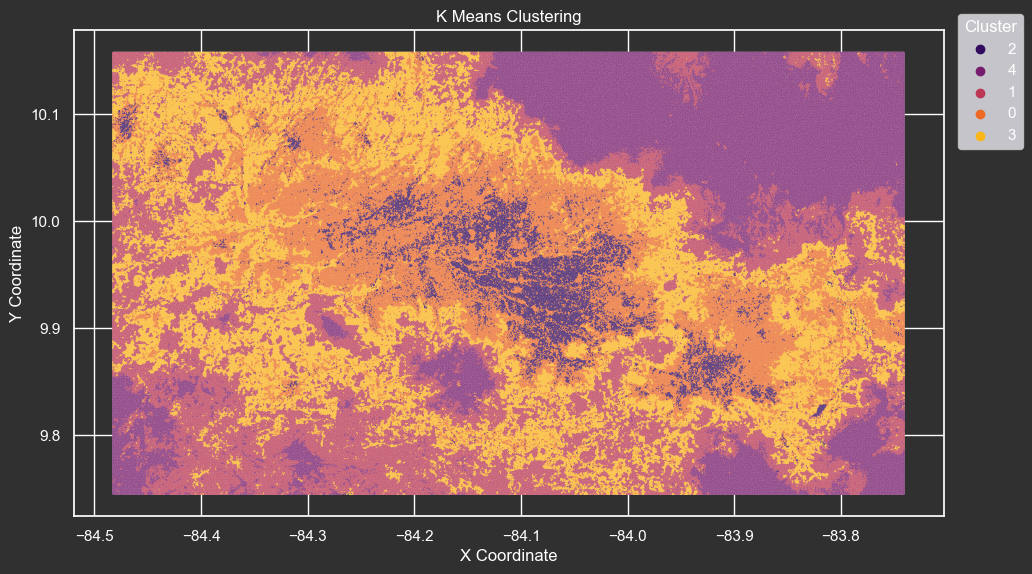

In [46]:
# Step 1: Calculate new value
df['IntegratedRisk'] = df['BII'] * df['OtherProbability']

# Step 2 & 3: Calculate mean by cluster and order clusters
cluster_means = df.groupby('cluster')['IntegratedRisk'].mean().sort_values()
# Get sorted cluster order
sorted_clusters = cluster_means.index.tolist()

# Step 4: Map this order to a new column in 'df' for color mapping
# Using 'category' data type ensures the plot uses this ordering
df['cluster_ordered'] = pd.Categorical(df['cluster'], categories=sorted_clusters, ordered=True)

# Now create the plot with adjustments
sns.set(style="darkgrid")

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x='x', 
    y='y', 
    hue='cluster_ordered',  # Use the new ordered cluster for coloring
    palette='inferno',  # Use 'inferno' palette
    data=df, 
    s=0.5  # Point size
)

# Adding title and labels with a light color for visibility against the dark background
plt.title('K Means Clustering', color='white')
plt.xlabel('X Coordinate', color='white')
plt.ylabel('Y Coordinate', color='white')

# Adjust tick and label color for visibility
plt.xticks(color='white')
plt.yticks(color='white')

# Modify legend for better visibility on dark background
legend = plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.1, 1.05), frameon=True)
plt.setp(legend.get_texts(), color='white')  # Set the legend text color to white for dark background
plt.setp(legend.get_title(), color='white')  # Set the legend title color to white

# Set face and edge color of the figure to match the dark theme
plt.gcf().set_facecolor('#303030')
plt.gca().set_facecolor('#303030')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['right'].set_color('white')

# Display the plot
plt.show()

Cluster 0, shown in RED is the zone at highest risk of biodiversity loss.
Prioritization: Conservation

Cluster 1, shown in GREEN is the zone where development risk is low and the suitability of urban development is high. 

Cluster 2

Cluster 3...

Now we'll export the data from clusters 1 and 2 for a secondary round of cluster analysis

In [47]:
# def export_clusters_to_csv(df, outputs):
#     # Iterate over each unique cluster value in the DataFrame
#     for cluster in df['cluster'].unique():
#         # Filter the DataFrame for rows where 'cluster' equals the current value
#         subset_df = df[df['cluster'] == cluster]
        
#         # Drop the 'cluster' column
#         subset_df = subset_df.drop(columns=['cluster', 'cluster_ordered', 'IntegratedRisk'])
        
#         # Format the filename using the current cluster number
#         filename = f'cluster_{cluster}_data.csv'
        
#         # Concatenate the directory and filename to get the full output path
#         csv_file_path = outputs + filename
        
#         # Export the DataFrame to a CSV file
#         subset_df.to_csv(csv_file_path, index=False)
#         print(f'Exported {csv_file_path}')

# #Run export function to save the clusters to CSV files:
# export_clusters_to_csv(df, outputs)


In [49]:
# Open the raster dataset and read its bounds and resolution
with rasterio.open(alignment) as dataset:
    bounds = dataset.bounds
    resolution_x, resolution_y = dataset.res  # Resolution in units of the dataset's CRS
    crs = dataset.crs  # Coordinate Reference System of the original raster

transform = dataset.transform

# Use the bounds from the original raster for setting up your analysis
x_min, x_max = bounds.left, bounds.right
y_min, y_max = bounds.bottom, bounds.top

# Assuming that the resolution is uniform in both directions, or choosing one as standard
resolution = resolution_x  # or resolution_y, if different and more appropriate


# Calculate grid dimensions correctly, adding 1 to ensure coverage
width = int(np.ceil((x_max - x_min) / resolution))
height = int(np.ceil((y_max - y_min) / resolution))

# Initialize grid with a nodata value
grid = np.full((height, width), -9999)  # Nodata value

# Assign cluster values to the grid
for _, row in df.iterrows():
    x_idx = int((row['x'] - x_min) / resolution)
    y_idx = int((row['y'] - y_min) / resolution)
    # Ensure indices are within bounds
    if 0 <= x_idx < width and 0 <= y_idx < height:
        grid[height - 1 - y_idx, x_idx] = row['cluster']  # Flip y-axis to match image coordinates

# Correct the CRS specification using a valid EPSG code
crs = "EPSG:4326"  # WGS84 Latitude/Longitude system

# Define geospatial metadata including the corrected CRS
meta = {
    'driver': 'GTiff',
    'dtype': 'float32',
    'nodata': -9999,
    'width': width,
    'height': height,
    'count': 1,
    'crs': crs,  # Corrected CRS specification
    'transform': transform
}

# Specify the filename
filename = f'{version}_clusters.tif'

# Concatenate the directory and filename to get the full output path
output_path = outputs + filename

# Save to GeoTIFF
with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(grid.astype(np.float32), 1)


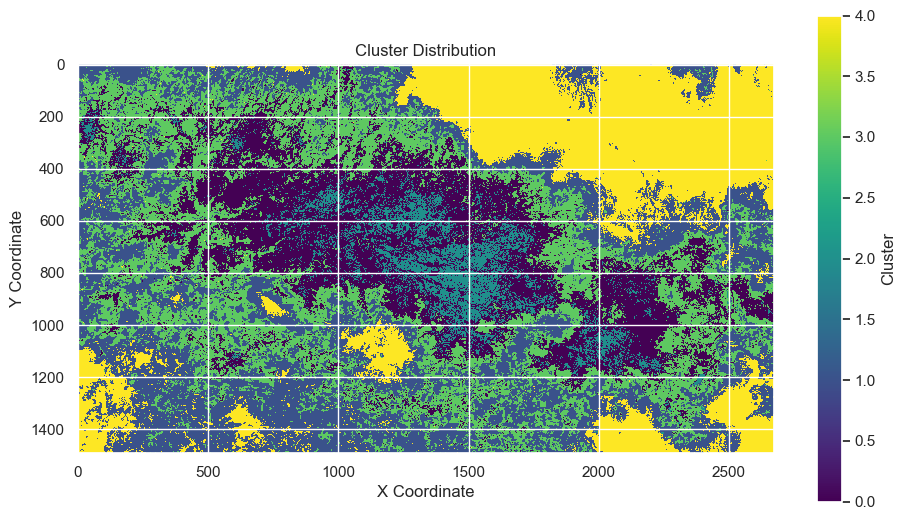

In [50]:
# Plot the Exported Raster
# Note: We're using a masked array to handle the nodata values correctly in the plot
masked_grid = np.ma.masked_where(grid == -9999, grid)

plt.figure(figsize=(10, 6))
plt.imshow(masked_grid, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Cluster')
plt.title('Cluster Distribution')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()